# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [61]:
# Import numpy and pandas
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot

import matplotlib.pyplot as plt
from pylab import rcParams

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.validation import array_like

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error

plt.style.use('fivethirtyeight')


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
# Your code here:

sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
# Your code here:
sensor.isnull().sum()


attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [5]:
# Your code here:

sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [6]:
def time_features(df): 
    """
    Esta función extrae características de tiempo 
    a una columna de fecha.
    """

    df = df.copy()

    df['date'] = df.index
    df['hour'] = df.date.dt.hour
    df['day_of_week'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['day_of_year'] = df.date.dt.dayofyear
    df['day_of_month'] = df.date.dt.day
    df['week_of_year'] = df.date.dt.weekofyear
    
    return df

In [7]:
# Your code here:

time_range = pd.date_range(start='01/01/2018 00:00:00',
                            end='01/01/2018 00:29:10',
                            freq='1s')

len(time_range)




1751

Assign the time series index to the dataframe's index.

In [8]:
# Your code here:
sensor = sensor.set_index(time_range)
sensor



,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:29:06,1.797120,-0.562324,2.445889,0.824443,0.533154,0.189844,-0.123211,0.909536,-0.379757,-0.268367,0.006733,-0.064874
2018-01-01 00:29:07,1.814297,-0.569719,2.449655,0.817212,0.539396,0.203020,-0.057641,0.723118,-0.437812,-0.102444,-0.060666,-0.229738
2018-01-01 00:29:08,1.830821,-0.578367,2.447967,0.809207,0.546658,0.215288,0.343238,0.997236,-0.338155,-0.085590,-0.030209,-0.087740
2018-01-01 00:29:09,1.849557,-0.586962,2.439458,0.800485,0.553834,0.229110,0.470144,1.227937,-0.332223,-0.048105,0.029555,0.060441


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [11]:
sensor_user_acc_x = pd.DataFrame(sensor['userAcceleration.x'])
sensor_user_acc_x.head()

,userAcceleration.x
2018-01-01 00:00:00,0.294894
2018-01-01 00:00:01,0.219405
2018-01-01 00:00:02,0.010714
2018-01-01 00:00:03,-0.008389
2018-01-01 00:00:04,0.199441


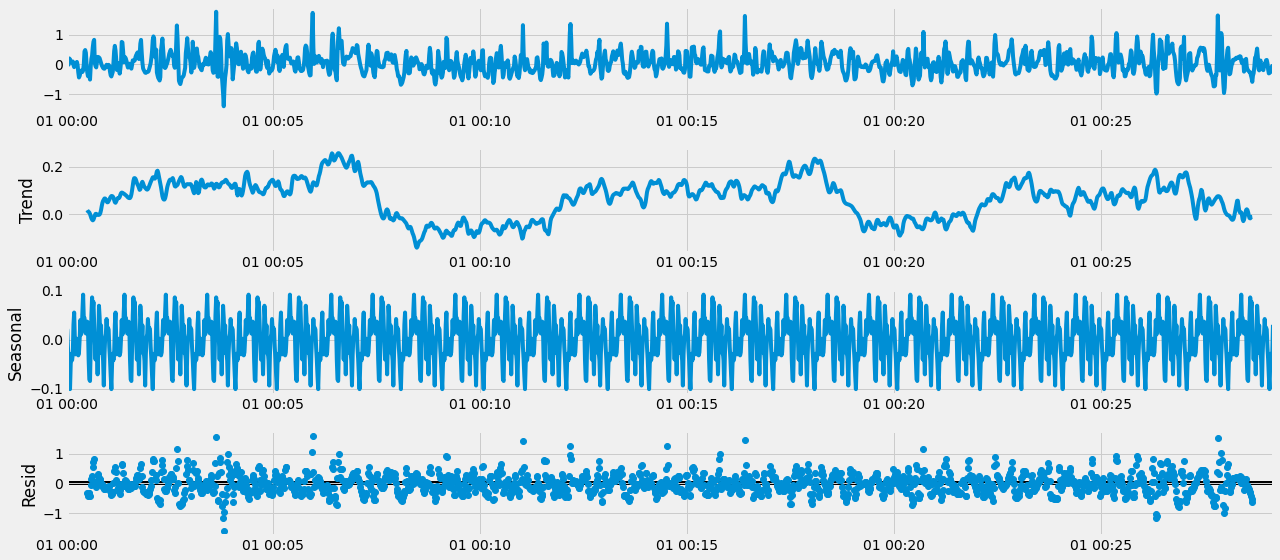

In [12]:
# Your code here:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(sensor_user_acc_x, period=60)
fig = decomposition.plot()
plt.show();



Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

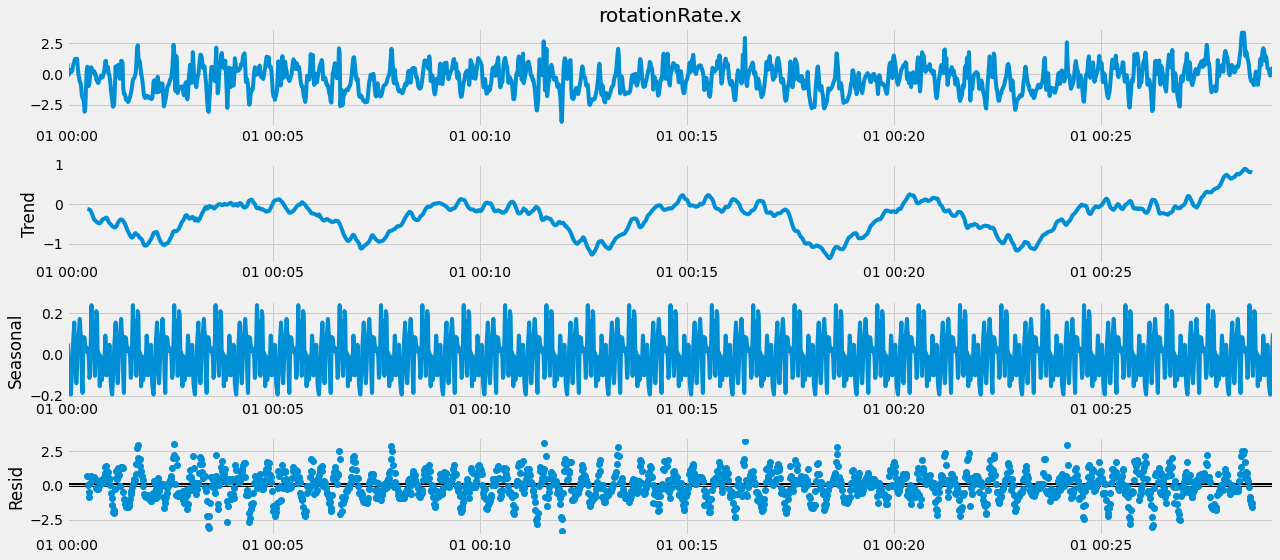

In [15]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(sensor['rotationRate.x'], period=60)
fig = decomposition.plot()
plt.show();


# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

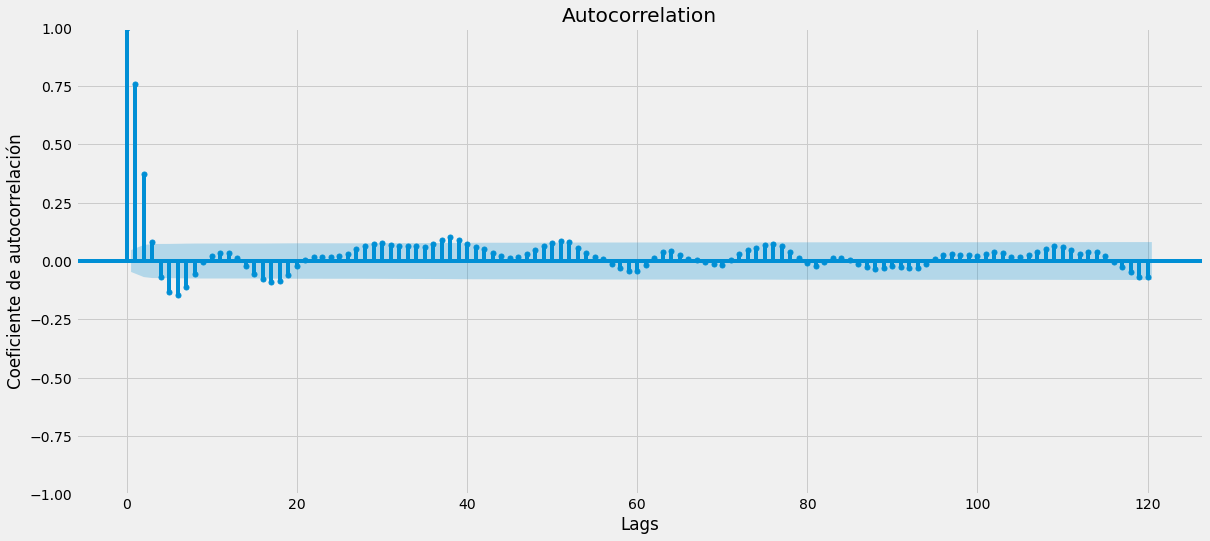

In [16]:
# Your code here:
tsaplots.plot_acf(sensor_user_acc_x.values.squeeze(), lags=120)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de autocorrelación')
plt.show()


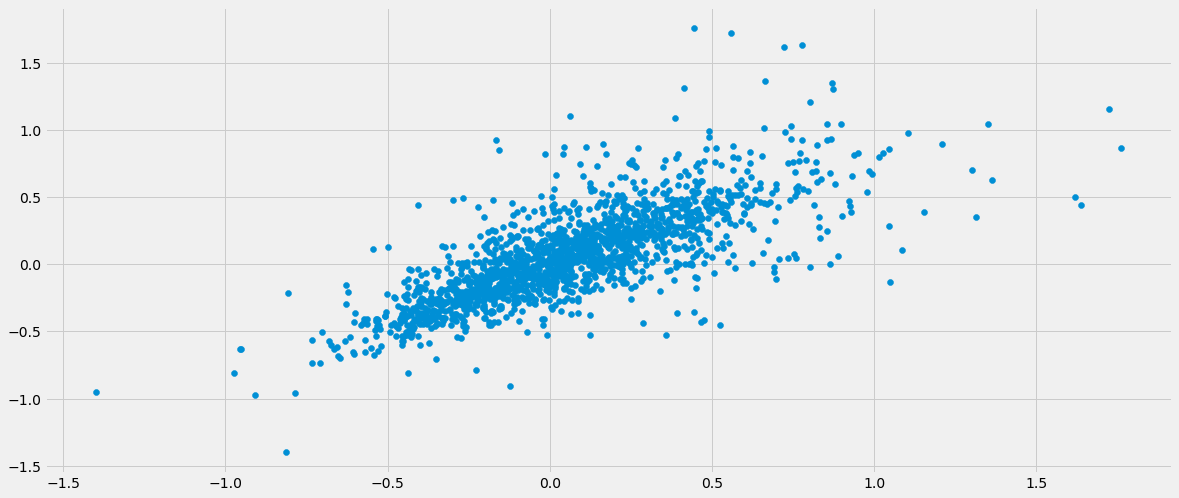

In [17]:
plt.scatter(sensor_user_acc_x, sensor_user_acc_x.shift(1));

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

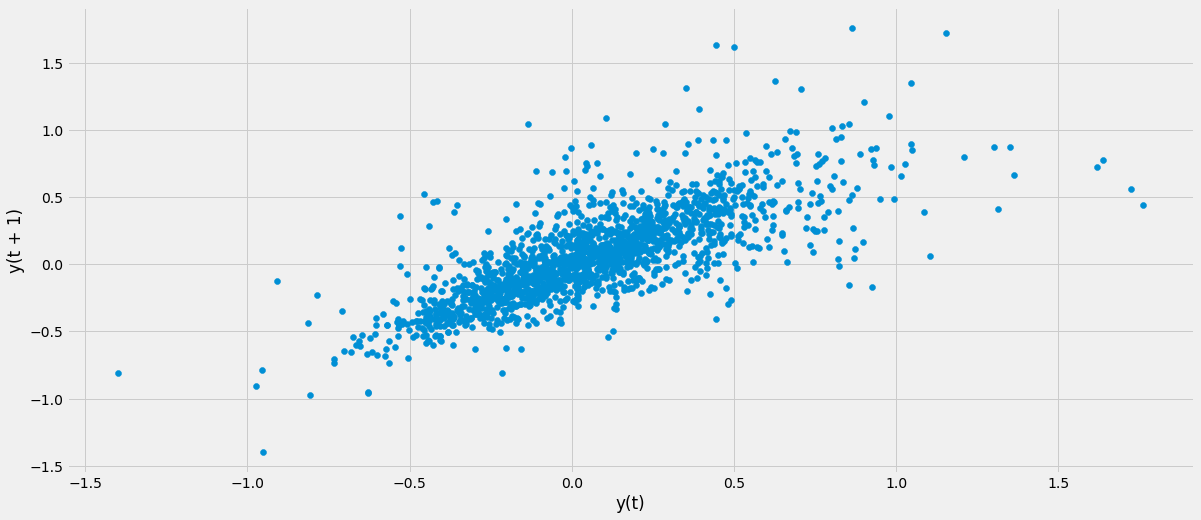

In [62]:
lag_plot(sensor_user_acc_x)

Create a lag plot for `rotationRate.x`

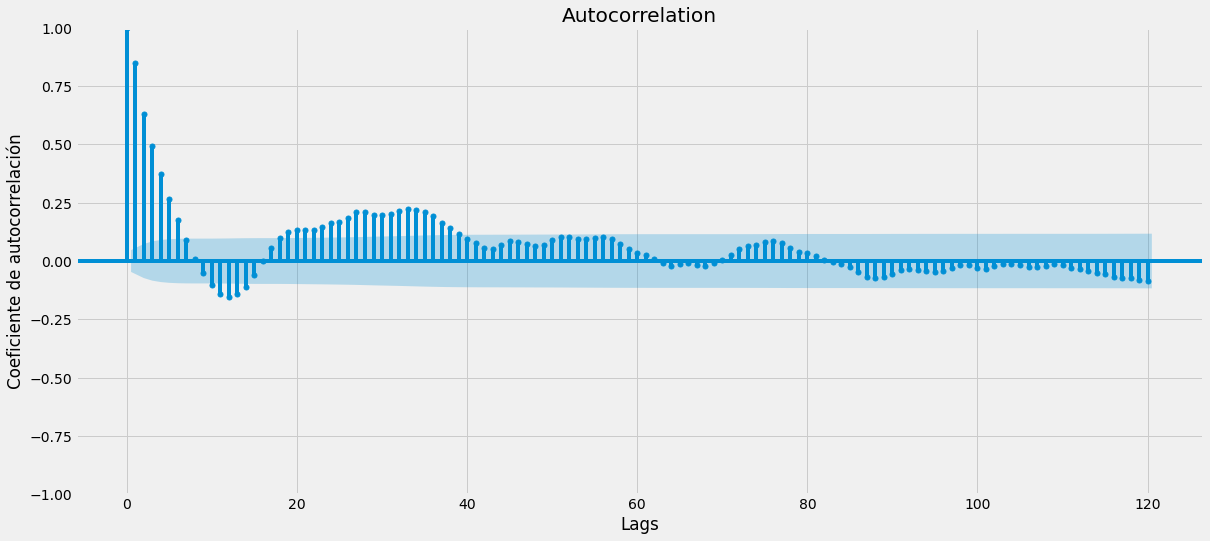

In [18]:
# Your code here:
tsaplots.plot_acf(sensor['rotationRate.x'].values.squeeze(), lags=120)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de autocorrelación')
plt.show()


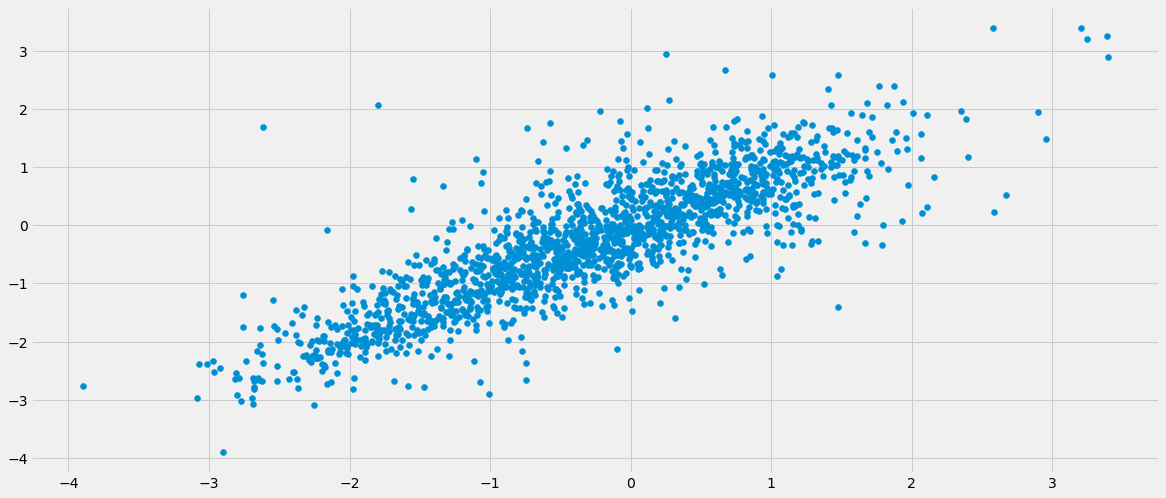

In [19]:
plt.scatter(sensor['rotationRate.x'], sensor['rotationRate.x'].shift(1))

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

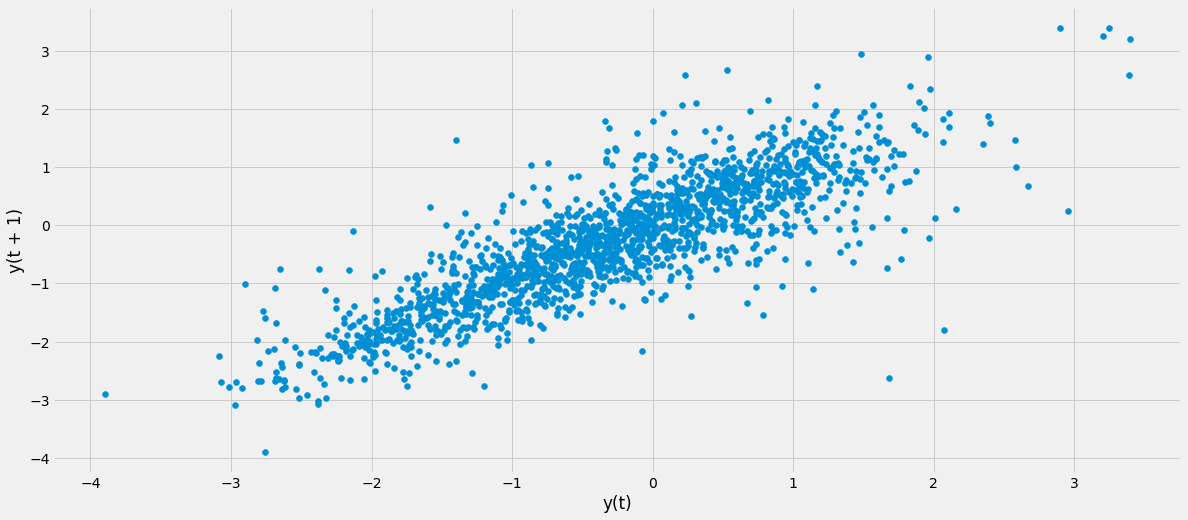

In [63]:
lag_plot(sensor['rotationRate.x'])

What are your conclusions from both visualizations?

In [20]:
# Your conclusions here:

# There is autocorrelation for rorationRate.x, but not for userAcceleration.X

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [21]:
# Your code here:

class Stationary:
    def __init__(self, significance=0.05):
        self.significance_level = significance
        self.pvalue = None
        self.is_stationary = None

    def ADF(self, values):
        result = adfuller(values, autolag='AIC')

        format_results = pd.Series(result[:4], 
                                    index=['Statistic', 'P-value',
                                        'Num of Lags', 'Observations'])
        for k,v in result[4].items():
            format_results[f'Critical Value {k}'] = v

        return format_results

In [22]:
adf_test = Stationary()
adf_test.ADF(sensor_user_acc_x.values).round(5)

Statistic              -17.95799
P-value                  0.00000
Num of Lags              4.00000
Observations          1746.00000
Critical Value 1%       -3.43410
Critical Value 5%       -2.86320
Critical Value 10%      -2.56765
dtype: float64

In [23]:
adf_test = Stationary()
adf_test.ADF(sensor['rotationRate.x'].values).round(5)

Statistic               -5.26986
P-value                  0.00001
Num of Lags             25.00000
Observations          1725.00000
Critical Value 1%       -3.43415
Critical Value 5%       -2.86322
Critical Value 10%      -2.56766
dtype: float64

What are your conclusions from this test?

In [24]:
# Your conclusions here:

# Ambas series son estacionarias, en ambas variables se rechaza la H0.

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [25]:
# Your code here:
model_userAcc_x = SARIMAX(sensor_user_acc_x, 
                    order=(2,0,1), 
                    enforce_stationarity=False)

results = model_userAcc_x.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     userAcceleration.x   No. Observations:                 1751
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 369.647
Date:                Tue, 10 May 2022   AIC                           -731.294
Time:                        16:15:22   BIC                           -709.427
Sample:                    01-01-2018   HQIC                          -723.211
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9827      0.036     27.439      0.000       0.913       1.053
ar.L2         -0.3619      0.033    -10.941      0.000      -0.427      -0.297
ma.L1          0.1982      0.039      5.048      0.000       0.121       0.275
sigma2         0.0384      0.001     49.789      0.000       0.037       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              1886.06
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.32
Prob(H) (two-sided):                  0.74   Kurtosis:                         8.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

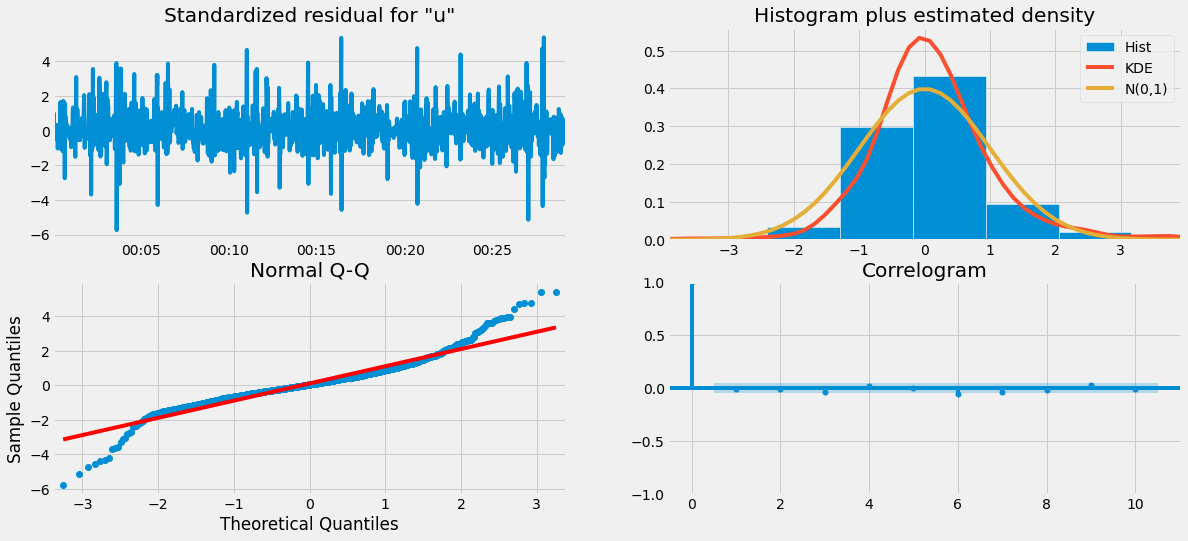

In [26]:
results.plot_diagnostics()
plt.show()

In [27]:
sensor_user_acc_x.reset_index().iloc[1750,0]
sensor_user_acc_x.tail(10)

,userAcceleration.x
2018-01-01 00:29:01,0.149749
2018-01-01 00:29:02,0.038461
2018-01-01 00:29:03,-0.169175
2018-01-01 00:29:04,-0.300361
2018-01-01 00:29:05,-0.270174
2018-01-01 00:29:06,-0.268367
2018-01-01 00:29:07,-0.102444
2018-01-01 00:29:08,-0.085590
2018-01-01 00:29:09,-0.048105
2018-01-01 00:29:10,-0.065011


In [36]:
# Your code here:
# sensor.reset_index().iloc[1751,0]

start = sensor_user_acc_x.reset_index().iloc[1741, 0]
end = sensor_user_acc_x.reset_index().iloc[-1, 0]

start, end

(Timestamp('2018-01-01 00:29:01'), Timestamp('2018-01-01 00:29:10'))

In [37]:
pred = results.predict(start=start, end=end)
pred

2018-01-01 00:29:01    0.153923
2018-01-01 00:29:02    0.095589
2018-01-01 00:29:03   -0.027727
2018-01-01 00:29:04   -0.208214
2018-01-01 00:29:05   -0.252211
2018-01-01 00:29:06   -0.160358
2018-01-01 00:29:07   -0.187357
2018-01-01 00:29:08    0.013289
2018-01-01 00:29:09   -0.066633
2018-01-01 00:29:10   -0.012623
Freq: S, Name: predicted_mean, dtype: float64

In [38]:
pred_ci = results.get_prediction(start=start, end=end).conf_int()
pred_ci

,lower userAcceleration.x,upper userAcceleration.x
2018-01-01 00:29:01,-0.229968,0.537814
2018-01-01 00:29:02,-0.288302,0.479480
2018-01-01 00:29:03,-0.411618,0.356164
2018-01-01 00:29:04,-0.592104,0.175677
2018-01-01 00:29:05,-0.636102,0.131680
2018-01-01 00:29:06,-0.544249,0.223533
2018-01-01 00:29:07,-0.571248,0.196534
2018-01-01 00:29:08,-0.370602,0.397180
2018-01-01 00:29:09,-0.450524,0.317257
2018-01-01 00:29:10,-0.396514,0.371267


In [52]:
df_pred = pd.DataFrame(pred)
df_pred.columns = ['userAcceleration.x']

In [53]:
df_pred.head(10)

,userAcceleration.x
2018-01-01 00:29:01,0.153923
2018-01-01 00:29:02,0.095589
2018-01-01 00:29:03,-0.027727
2018-01-01 00:29:04,-0.208214
2018-01-01 00:29:05,-0.252211
2018-01-01 00:29:06,-0.160358
2018-01-01 00:29:07,-0.187357
2018-01-01 00:29:08,0.013289
2018-01-01 00:29:09,-0.066633
2018-01-01 00:29:10,-0.012623


To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [58]:
# Your code here:
y_test = sensor_user_acc_x.tail(10)

mse(y_test, df_pred) ** 0.5


0.07990196687336525